In [28]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.style.use('seaborn-notebook')
%matplotlib inline
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import src.scrubbing_develop as scrubbing
import src.evaluation_develop as evalu
from src.roc import plot_roc

In [29]:
df2 = pd.read_pickle('data/sf_inspection_master.pkl')
df7 = scrubbing.remove_rows_zero_violation2(df2) 

## Find out the total number of restaurants in the SF health inspection report

In [30]:
df7.head(1)

,business_id,business_name,business_address,business_city,business_state,business_postal_code,business_latitude,business_longitude,business_location,business_phone_number,...,94133,94134,94143,94158,95105,rating,price,longitude_round,latitude_round,p7_36
0,1757,Dar Bar Pakistani/Indian Cusine,1412 Polk St,San Francisco,CA,94109,37.789784,-122.420455,"(37.789784, -122.420455)",NaN,...,0,0,0,0,0,3.69502,1.769068,-122.42,37.79,16


In [31]:
f1034 = df7['business_address'].unique()

In [32]:
len(list(f1034))

4533

## Import clean data from pickle

In [33]:
df8 = pd.read_pickle('data/sf_inspection_master.pkl')

## Modeling: logistic regression and gradient boosting

In [34]:
y = df8['y_label']
X = df8[['p7_9', 'p10_12', 'p13_18', 'p19_24', 'p25_36', '94013', '94014', '94080', '94101', '94102', '94103', '94104',
       '94105', '94107', '94108', '94109', '94110', '94111', '94112', '94114',
       '94115', '94116', '94117', '94118', '94120', '94121', '94122', '94123',
       '94124', '94127', '94129', '94130', '94131', '94132', '94133', '94134',
       '94143', '94158']]

In [35]:
X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=0.25, random_state=38)

### Let's stash X_test and y_test away for only test set purpose. Split X_train and y_train again for train and validation.

In [36]:
X_train, X_validation, y_train, y_validation = train_test_split(X_tr, y_tr, test_size=0.25, random_state=28)

In [37]:
log_model = LogisticRegression()
log_model.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [38]:
log_model.coef_

array([[-0.47048322, -0.28029293, -0.02104173,  0.10616238,  0.05451191,
        -0.40293333,  0.        ,  0.47832549, -0.01603694, -0.03297594,
         0.62469292,  1.00560232,  0.32266711, -0.6105317 ,  0.03879945,
         1.34620127,  1.64581064, -0.3657547 ,  0.4305868 ,  0.56455026,
        -0.96530966,  0.47529062, -0.09956593,  0.10621751, -0.32942257,
         0.12525264,  0.46584614,  1.78438758, -0.3569133 ,  0.32812983,
        -0.34708005, -0.31215025, -0.1601733 ,  0.78288208,  0.62020704,
         0.44298405,  0.65091682, -1.01424429]])

In [39]:
log_model.intercept_

array([-0.39519541])

In [40]:
log_model.score(X_validation, y_validation)

0.6639427987742594

# Gradient Boosting Model

In [41]:
learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
for learning_rate in learning_rates:
    gb = GradientBoostingClassifier(n_estimators=20, learning_rate = learning_rate, max_features=2, max_depth = 2, random_state = 0)
    gb.fit(X_train, y_train)
    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb.score(X_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(gb.score(X_validation, y_validation)))

Learning rate:  0.05
Accuracy score (training): 0.555
Accuracy score (validation): 0.571
Learning rate:  0.1
Accuracy score (training): 0.594
Accuracy score (validation): 0.601
Learning rate:  0.25
Accuracy score (training): 0.678
Accuracy score (validation): 0.655
Learning rate:  0.5
Accuracy score (training): 0.704
Accuracy score (validation): 0.668
Learning rate:  0.75
Accuracy score (training): 0.707
Accuracy score (validation): 0.668
Learning rate:  1
Accuracy score (training): 0.705
Accuracy score (validation): 0.665


In [42]:
# Let's use learning rate of 0.75
gb = GradientBoostingClassifier(n_estimators=20, learning_rate = 0.75, max_features=2, max_depth = 2, random_state = 0)
gb.fit(X_train, y_train)
print("Accuracy score (training): {0:.3f}".format(gb.score(X_train, y_train)))
print("Accuracy score (validation): {0:.3f}".format(gb.score(X_validation, y_validation)))
# The "validation" here is a correct term. It is not a "test" set.

Accuracy score (training): 0.707
Accuracy score (validation): 0.668


### Cofusion matrix

In [43]:
y_predictions = gb.predict(X_test)

In [44]:
tn, fp, fn, tp = confusion_matrix(y_test, y_predictions).ravel()

In [45]:
print("True Negative: {}".format(tn))
print("True Positive: {}".format(tp))
print("False Negative: {}".format(fn))
print("False Positive: {}".format(fp))

True Negative: 477
True Positive: 440
False Negative: 201
False Positive: 187


In [46]:
#y = int(y.values == True)
ay = y[:]
ay = 1*y.values

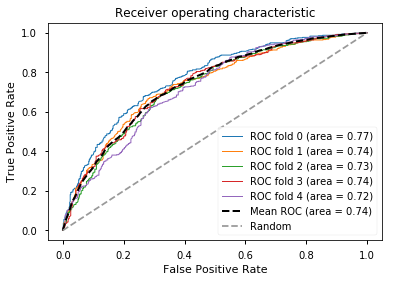

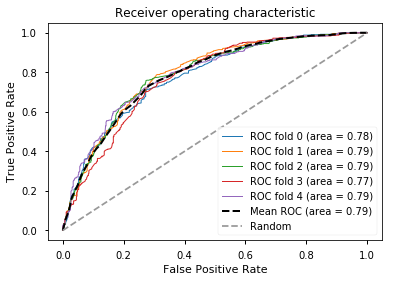


Plotting completed.


In [47]:
plot_roc(X, ay, LogisticRegression)
plot_roc(X, ay, GradientBoostingClassifier)
# plot_roc(X, y, MultinomialNB) error
print('\nPlotting completed.')

### Plotting Methods

In [48]:
def plot_roc(y_test, X_test, model, model_name):
    AUC = roc_auc_score(y_test, gb.predict_proba(X_test)[:,1])
    fpr, tpr, thresholds = roc_curve(y_test, gb.predict_proba(X_test)[:,1])
    
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % AUC)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic {}'.format(model_name))
    plt.legend(loc="lower right");

In [49]:
def plot_profit_curve(scoring, profit_matrix, num_points=100):
    x_threshold, y_profit = scoring.profit_curve(num_points=num_points, profit_matrix=profit_matrix)
    
    fig, ax = plt.subplots()
    ax.plot(x_threshold, y_profit)
    
    ymax = max(y_profit)
    xpos = y_profit.index(ymax)
    xmax = x_threshold[xpos]
    
    text= "x={:.3f}, y={:.3f}".format(xmax, ymax)
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=180,angleB=60")
    kw = dict(xycoords='data',textcoords="axes fraction", arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmax, ymax), xytext=(0.94,0.96), **kw)
    #ax.set_ylim(min(y_profit), ymax*2)
    ax.set_ylim(min(y_profit), ymax*1.7)
    ax.set_xlabel('Threshold For Predicting Inspection Fail')
    ax.set_ylabel('Profit')
    ax.set_title('Profit Curve')
    plt.show()

## Profit curve

In [50]:
scoring = evalu.Scores(model=gb, X_test=X_test, y_test=y_test)
scoring.scores()

Accuracy: 0.7026819923371648
Precision 0.7017543859649122
Recall 0.6864274570982839
F1 0.694006309148265


In [51]:
# customer, investment on facility/training, fine by the city
investment = 40  # equipment replacement and employee training
fine = 80   # penalty by the city 

false_pos = (-1)*investment
true_pos  = fine - investment
false_neg = 0
true_neg  = 0

profit_matrix = [[true_neg, false_pos],[false_neg, true_pos]]

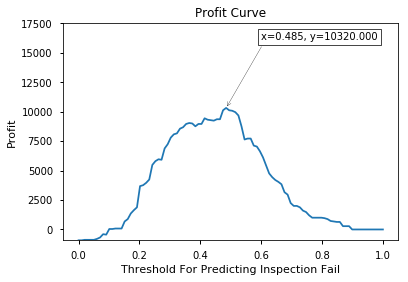

In [52]:
plot_profit_curve(scoring, profit_matrix, num_points=100)